In [ ]:
import tkinter as tk
from tkinter import filedialog

import scipy.io
import os
import numpy as np
import sys
import textgrids
import spyeeg

import gc

from funcs import vhdr_to_mne, bipolar_montage, prepare_data, concatenation,load_sorciere_regressors

c:\Users\nadege\anaconda3\envs\mon_env_mne_2\python.exe
c:\Users\nadege\anaconda3\envs\mon_env_mne_2\lib\site-packages\spyeeg\__init__.py


## paths

In [9]:
# first 'select a folder direction 'patient espace''
# then, select the sorciere file in the NAS (sorcière = file.vhdr)
# then, select the pianos files in the NAS (pianos = [file.vhdr, file.vhdr..]
# Fonction pour sélectionner le chemin vers le dossier "sorciere"
def select_sorciere_path():
    global sorciere_path
    sorciere_path = filedialog.askopenfilenames()
    if sorciere_path:
        print("Fichiers sélectionnés:")
        for file in sorciere_path:
            print(file)

#  Fonction pour sélectionner le chemin vers le dossier "piano"
def select_piano_path():
    global piano_path
    piano_path = filedialog.askopenfilenames()
    if piano_path:
        print("Fichiers sélectionnés:")
        for file in piano_path:
            print(file)


# Fonction pour sélectionner le chemin vers le dossier de sortie
def select_out_path():
    global out_path
    out_path = filedialog.askdirectory()
    if out_path:
        print("Chemin vers le dossier de sortie sélectionné:", out_path)

# Création de la fenêtre principale
root = tk.Tk()
root.title("Ouvrir")

# Déclaration des variables pour stocker les chemins sélectionnés
sorciere_path = ""
piano_path = ""
out_path = ""

# Boutons pour sélectionner les chemins vers les dossiers
sorciere_button = tk.Button(root, text="Select Sorcière *.vhdr (on NAS)", command=select_sorciere_path)
sorciere_button.pack(pady=5)

piano_button = tk.Button(root, text="Select Pianos *.vhdr (on NAS)", command=select_piano_path)
piano_button.pack(pady=5)

out_button = tk.Button(root, text="Select patient workspace (locally)", command=select_out_path)
out_button.pack(pady=5)

root.mainloop()

# Vous pouvez maintenant utiliser les variables sorciere_path, piano_path et out_path dans votre application.


Chemin vers le dossier de sortie sélectionné: C:/Users/nadege/Desktop/camille/seeg/agnes/Gab_Sa/1000permut
Fichiers sélectionnés:
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Sorcière/250123C-B_0005.vhdr
Fichiers sélectionnés:
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0008.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0010.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0012.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0014.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0017.vhdr


## Import .vhdr to mne

In [10]:
sorciere_mne = vhdr_to_mne(sorciere_path)
pianos_mne = vhdr_to_mne(piano_path)

//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Sorcière/250123C-B_0005.vhdr
250123C-B_0005.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0008.vhdr
250123C-B_0008.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0010.vhdr
250123C-B_0010.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0012.vhdr
250123C-B_0012.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0014.vhdr
250123C-B_0014.vhdr
//139.124.148.123/seeg/Seeg_1998-2025/Seeg2025/sEEG_03_Gab_Sa/23.01/Piano/250123C-B_0017.vhdr
250123C-B_0017.vhdr


In [11]:
piano_path, file = os.path.split(piano_path[0])
sorciere_path, file = os.path.split(sorciere_path[0])
del file

In [12]:
stim_piano = [file for file in os.listdir(piano_path+'/stim') if os.path.isfile(os.path.join(piano_path+'/stim', file)) and file.endswith('.mp3')]
stim_sorcière = [file for file in os.listdir(sorciere_path+'/stim') if os.path.isfile(os.path.join(sorciere_path+'/stim', file)) and file.endswith('.mp3')]

## Montage bipolaire

Do a bipolar montage en soustrayant l'activité de deux shaft consécutives /!\ de le même electrode

In [13]:
sorciere_bipol, channels_bipol = bipolar_montage(sorciere_mne[0], chans=True)
sorciere_bipol = [sorciere_bipol]

pianos_bipol = []
for piano in pianos_mne :
    pianos_bipol.append(bipolar_montage(piano, chans=False))

In [14]:
#Trier les channels dans l'ordre alphabétique et numérique
def custom_sort(value):
    # Séparer la partie alphabétique et numérique
    alpha_part = ''.join(filter(lambda x: x.isalpha() or x == "'", value))
    num_part = int(''.join(filter(str.isdigit, value)))
    return alpha_part, num_part

sorted_channels_bipol = sorted(channels_bipol, key=custom_sort)

# Sorciere
sorciere_bipol_sorted = [np.empty_like(sorciere_bipol[0])]
for i, channel_name in enumerate(sorted_channels_bipol):
    channel_index = channels_bipol.index(channel_name)
    sorciere_bipol_sorted[0][:, i] = sorciere_bipol[0][:, channel_index]

# Pianos
pianos_bipol_sorted = []
for piano in pianos_bipol :
    sorted_piano_bipol = np.empty_like(piano)
    for i, channel_name in enumerate(sorted_channels_bipol):
        channel_index = channels_bipol.index(channel_name)
        sorted_piano_bipol[:, i] = piano[:, channel_index]
    pianos_bipol_sorted.append(sorted_piano_bipol)

del sorted_piano_bipol

In [15]:
scipy.io.savemat(out_path+'/channels.mat', {'ch':np.array(sorted_channels_bipol)})

In [16]:
import mne
from pydub import AudioSegment
from collections import Counter
import matplotlib.pyplot as plt
from scipy.signal import correlate

def align_origin(raw_fif, raw_array, stim_dir) :
  stim_name = os.path.basename(stim_dir)

  #load .mp3
  aud = AudioSegment.from_file(stim_dir, format="mp3")
  fs_stim = aud.frame_rate

  # stereo format : audio/trigger
  chans = aud.split_to_mono()
  trigg = chans[1].get_array_of_samples()  # triggers

  # binarized triggers
  thrsh_exceed_idx = []
  seuil = 3000
  for idx, valeur in enumerate(trigg):
    if valeur > seuil and trigg[idx - 1] < seuil and trigg[idx - 2] < seuil:
      thrsh_exceed_idx.append(idx)

  trigg_stim = np.array(thrsh_exceed_idx)
  trigg_stim = trigg_stim / fs_stim

  # load data
  fs_data = raw_fif.info['sfreq']

  # find events
  orig_events, events_dict = mne.events_from_annotations(raw_fif)
  #take only trigg of interest
  counter = Counter(orig_events[:, 2])
  t_int = counter.most_common(1)[0][0]
  trigg_data_samples = np.squeeze(orig_events[np.where(orig_events[:, 2] == t_int), 0])
  #trigg_data_samples = trigg_data_samples[5:]
  trigg_data_secondes = trigg_data_samples / fs_data

  # plt.figure()
  # plt.vlines(trigg_data_secondes, 0,1, label = "trigg_data")
  # plt.vlines(trigg_stim, 1,2, color='orange', label = "trigg_stim")
  # plt.xlim(0,10)
  # plt.legend()
  # plt.title("before alignement")

  print('data :', len(trigg_data_secondes))
  print('stim :', len(trigg_stim))

  i=0
  max_iteration = 150
  while True:
    if len(trigg_data_secondes) == len(trigg_stim):
      print('same numbre of trigger')
      trigg_stim_zero = trigg_stim - trigg_stim[0]
      trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]

    elif len(trigg_data_secondes) < len(trigg_stim):
      print('< number of trigger')
      if i >= len(trigg_stim):  # Si i dépasse la taille de trigg_stim
          print(f"Stopping: i ({i}) exceeded trigg_stim size ({len(trigg_stim)})")
          break
      trigg_stim_zero = trigg_stim - trigg_stim[i]
      trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]

    elif len(trigg_data_secondes) > len(trigg_stim):
      print('> number of trigger')
      if i >= len(trigg_data_secondes):  # Si i dépasse la taille de trigg_data_secondes
          print(f"Stopping: i ({i}) exceeded trigg_data_secondes size ({len(trigg_data_secondes)})")
          break
      trigg_stim_zero = trigg_stim - trigg_stim[0]
      trigg_data_zero = trigg_data_secondes - trigg_data_secondes[i]

    # calcul delay between all triggs
    matrice_differences = np.zeros((len(trigg_data_zero), len(trigg_stim_zero)))
    for j in range(len(trigg_data_zero)):
      for k in range(len(trigg_stim_zero)):
        matrice_differences[j, k] = trigg_data_zero[j] - trigg_stim_zero[k]

    # take only closest pairs of trigger
    if len(trigg_data_zero) <= len(trigg_stim_zero):
      trigg_stim_zero_syncr = []
      for j in range(len(trigg_data_zero)):
        idx_syncr = np.argmin(np.abs(matrice_differences[j, :]))
        trigg_stim_zero_syncr.append(trigg_stim_zero[idx_syncr])
      # calcul delay between closest pairs
      matrice_differences_ = np.zeros((len(trigg_data_zero), len(trigg_stim_zero_syncr)))
      for j in range(len(trigg_data_zero)):
        for k in range(len(trigg_stim_zero_syncr)):
          matrice_differences_[j, k] = trigg_data_zero[j] - trigg_stim_zero_syncr[k]
      # calcul delay between closest pairs
      matrice_differences_ = np.zeros((len(trigg_data_zero), len(trigg_stim_zero_syncr)))
      for j in range(len(trigg_data_zero)):
        for k in range(len(trigg_stim_zero_syncr)):
          matrice_differences_[j, k] = trigg_data_zero[j] - trigg_stim_zero_syncr[k]

    elif len(trigg_data_zero) > len(trigg_stim_zero):
      trigg_data_zero_syncr = []
      for j in range(len(trigg_stim_zero)):
        idx_syncr = np.argmin(np.abs(matrice_differences[:, j]))
        trigg_data_zero_syncr.append(trigg_data_zero[idx_syncr])
      # calcul delay between closest pairs
      matrice_differences_ = np.zeros((len(trigg_data_zero_syncr), len(trigg_stim_zero)))
      for j in range(len(trigg_data_zero_syncr)):
        for k in range(len(trigg_stim_zero)):
          matrice_differences_[j, k] = trigg_data_zero_syncr[j] - trigg_stim_zero[k]
      # calcul delay between closest pairs
      matrice_differences_ = np.zeros((len(trigg_data_zero_syncr), len(trigg_stim_zero)))
      for j in range(len(trigg_data_zero_syncr)):
        for k in range(len(trigg_stim_zero)):
          matrice_differences_[j, k] = trigg_data_zero_syncr[j] - trigg_stim_zero[k]

    # mean delay
    tmp = np.mean(np.diagonal(matrice_differences_))
    print(np.abs(round(tmp, 4)))
    if np.abs(round(tmp, 4)) > 0.005 :
      i+=1
      continue

    else :
      if i == 0 :
        raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1],:]
        # plt.figure()
        # plt.vlines(trigg_data_zero, 0,1, label = "trigg_data")
        # plt.vlines(trigg_stim_zero, 1,2, color='orange', label = "trigg_stim")
        # plt.xlim(-1,10)
        # plt.legend()
        # plt.title("after alignement")
      else :
        if len(trigg_data_secondes) < len(trigg_stim):
          raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1],:]
          zrs = int((trigg_stim[i]-trigg_stim[0])*fs_data)
          add_zeros = np.zeros((zrs, raw_array_.shape[1]))
          raw_array_ = np.concatenate((add_zeros, raw_array_), axis=0)

        elif len(trigg_data_secondes) > len(trigg_stim):
          raw_array_ = raw_array[trigg_data_samples[i]:trigg_data_samples[-1],:]
      break

  return raw_array_

## Align

In [17]:
%matplotlib qt
sorciere_aligned = align_origin(raw_fif=sorciere_mne[0], raw_array=sorciere_bipol_sorted[0], stim_dir=os.path.join(sorciere_path,'stim', stim_sorcière[0]))

pianos_aligned=[]
for i in range(len(pianos_bipol_sorted)):
    pianos_aligned.append(align_origin(raw_fif=pianos_mne[i], raw_array=pianos_bipol_sorted[i], stim_dir=os.path.join(piano_path,'stim', stim_piano[i])))

Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Comment/Fin', 'Stimulus/S 128', 'Stimulus/S 192', 'Stimulus/S 200', 'Stimulus/S 201']
data : 584
stim : 585
< number of trigger
0.0014
Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Stimulus/S 192', 'Stimulus/S 200']
data : 146
stim : 152
< number of trigger
0.0145
< number of trigger
0.0289
< number of trigger
0.0335
< number of trigger
0.0244
< number of trigger
0.0732
< number of trigger
0.0424
< number of trigger
0.0007
Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Stimulus/S 192', 'Stimulus/S 200']
data : 102
stim : 103
< number of trigger
0.0005
Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Stimulus/S 192', 'Stimulus/S 200']
data : 129
stim : 130
< number of trigger
0.0007
Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Stimulus/S 192', 'Stimulus/S 200']
data : 185
stim : 187
< number of trigger
0.0015
Used Annotations descriptions: ['Comment/?', 'Commen

## Filtering 0.1-35Hz - Z-scoring - Downsampling

In [18]:
high_pass = 0.1
low_pass = 35

fs_data = sorciere_mne[0].info['sfreq']

pianos_downsampled = []

sorciere_ultimate = prepare_data(data= sorciere_aligned, picks=sorted_channels_bipol, high_pass=high_pass, low_pass=low_pass, fs_data=fs_data)
for data in pianos_aligned :
    print(data.shape)
    pianos_downsampled.append(prepare_data(data=data, picks=sorted_channels_bipol, high_pass=high_pass, low_pass=low_pass, fs_data=fs_data))

(78146, 212)
(50934, 212)
(65555, 212)
(93116, 212)
(27692, 212)


## Concatenate Pianos & Load Pianos regressors

In [19]:
# define and load concatenated data and regressors for piano
pianos_ultimate, pianos_regs_all, pianos_regs_all_labels, fs = concatenation(pianos_downsampled, piano_path, stim_piano)

## Load Sorcière regressors

In [20]:
sorciere_ultimate, sorciere_regs_all, sorciere_regs_all_label = load_sorciere_regressors(sorciere_path, sorciere_ultimate)

In [21]:
print("Socière regressors labels:")
for idx, label in enumerate(sorciere_regs_all_label):
    print(f"{idx}: {label}")

print("\nPianos regressors labels:")
for idx, label in enumerate(pianos_regs_all_labels):
    print(f"{idx}: {label}")


Socière regressors labels:
0: loudness
1: brightness
2: pitch
3: periodicity
4: roughness
5: spectral_flux
6: der_loudness
7: der_brightness
8: der_pitch
9: der_periodicity
10: der_roughness
11: der_spectral_flux
12: half_rectified_der_loudness
13: half_rectified_der_brightness
14: half_rectified_der_pitch
15: half_rectified_der_periodicity
16: half_rectified_der_roughness
17: half_rectified_der_spectral_flux
18: syllabe_onset
19: onsets
20: entropy
21: surprise

Pianos regressors labels:
0: envelope
1: der_envelope_hr
2: onset
3: surprise
4: surprise_positive


## Define models

In [103]:
X_sorc_full = np.squeeze(sorciere_regs_all)
label_to_index = {label: idx for idx, label in enumerate(sorciere_regs_all_label)}

acoustic_names = [
    'loudness', 'brightness', 'periodicity',
    'half_rectified_der_loudness', 'half_rectified_der_brightness', 'half_rectified_der_periodicity',
    'syllabe_onset','onsets'
]
predictive_names = ['entropy','surprise']

idx_acoustic = [label_to_index[n] for n in acoustic_names]
idx_predictive = [label_to_index[n] for n in predictive_names]

X_sorc_acoustic = X_sorc_full[:, idx_acoustic]
X_sorc_predictive = X_sorc_full[:, idx_predictive]


In [104]:
X_piano_full = np.squeeze(pianos_regs_all)
label_to_index = {label: idx for idx, label in enumerate(pianos_regs_all_labels)}

acoustic_names = ['envelope', 'der_envelope_hr','onset']
predictive_names = ['surprise', 'surprise_positive']

idx_acoustic = [label_to_index[n] for n in acoustic_names]
idx_predictive = [label_to_index[n] for n in predictive_names]

X_piano_acoustic = X_piano_full[:, idx_acoustic]
X_piano_predictive = X_piano_full[:, idx_predictive]


## TRF

In [105]:
from scipy.stats import zscore
import numpy as np

N_PERMUT = 200

def resample_and_shuffle_predictors(X, fs_old, fs_new, n_samples, n_permut):
    """
    Crée une matrice 3D contenant les versions réelles et permutées des régresseurs.
    
    Paramètres :
        X : array (n_time, n_regressors)
        fs_old : fréquence d'échantillonnage d'origine
        fs_new : fréquence cible (souvent identique à fs_old)
        n_samples : nombre d'échantillons cible (données EEG)
        n_permut : nombre de permutations
    
    Retour :
        X_resampled_shuffled : array (n_samples, n_regressors, n_permut+1)
    """

    onset_seconds = np.argwhere(X[:, 0]) / fs_old
    onset_sample = np.argwhere(X[:, 0])

    X_resampled_shuffled = np.zeros((n_samples, X.shape[1], n_permut + 1))

    for i in range(n_permut + 1):
        X_iter = np.zeros((n_samples, X.shape[1]))
        positions = np.round(onset_seconds * fs_new).astype(int).ravel()
        X_iter[positions, 0] = 1

        for k in range(1, X.shape[1]):
            values = zscore(X[onset_sample, k].flatten())
            if i == 0:
                X_iter[positions, k] = values
            else:
                np.random.shuffle(values)
                X_iter[positions, k] = values


        X_resampled_shuffled[:, :, i] = X_iter

    return X_resampled_shuffled


In [106]:
Xp_sorc_predictive = resample_and_shuffle_predictors(
    X=X_sorc_predictive,
    fs_old=fs,
    fs_new=fs,
    n_samples=sorciere_ultimate.shape[0],
    n_permut=N_PERMUT
)

Xp_piano_predictive = resample_and_shuffle_predictors(
    X=X_piano_predictive,
    fs_old=fs,
    fs_new=fs,
    n_samples=pianos_ultimate.shape[0],
    n_permut=N_PERMUT
)

print(Xp_sorc_predictive.shape)
print(Xp_piano_predictive.shape)

(57650, 2, 201)
(61198, 2, 201)


In [26]:
from datetime import datetime

start_at = datetime.now()

In [ ]:
n_folds = 5
tw_trf = [-0.3, 0.7]  #in sec

coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))  #get TRF time-axis

alphas = [1e-4, 1e-2, 1e2, 1e4, 1e6, 1e8]

C:\Users\nadege\AppData\Local\Temp\ipykernel_10148\3912274024.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))  #get TRF time-axis


### Sorcière : acoustic TRF

In [ ]:
from scipy.io import savemat
from sklearn.preprocessing import scale
import numpy as np
import gc

# Paramètres
coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))
alphas = [1e-4, 1e-2, 1e2, 1e4, 1e6, 1e8]

# Données : X = régressseurs acoustiques, Y = EEG
X = X_sorc_acoustic
Y = np.squeeze(sorciere_ultimate)

# TRF
trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain = 'frequency')
trf.xval_eval(X, Y, n_splits=5, fit_mode='direct', verbose=False)

# Sélection des meilleurs alpha par canal
best_alpha = trf.get_best_alpha()
r2 = trf.scores[
    np.arange(trf.scores.shape[0])[:, None],
    np.arange(trf.scores.shape[1])[None, :],
    best_alpha
]
r2_acoustic = np.mean(r2, axis=0)

# Coefficients associés
coef = trf.get_coef()
trf_betas_acoustic = coef[
    np.arange(coef.shape[0])[:, None, None],
    np.arange(coef.shape[1])[None, :, None],
    np.arange(coef.shape[2])[None, None, :],
    best_alpha
]

# Sauvegarde
savemat(out_path + '/sorciere_acoustic.mat', {
    'r2': r2_acoustic,
    'kernels': trf_betas_acoustic,
    'channels': sorted_channels_bipol,
    'fs': fs
})

gc.collect()
print("✅ Modèle acoustique sans permutation terminé et sauvegardé.")


C:\Users\nadege\AppData\Local\Temp\ipykernel_10148\1191170215.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))


✅ Modèle acoustique sans permutation terminé et sauvegardé.


### Sorcière : predictive TRF

In [ ]:
import os
import numpy as np
import scipy.io
from joblib import Parallel, delayed
from tqdm import tqdm  # Facultatif pour barre de progression

# ========= CONFIGURATION =========
N_PERMUT = 1000
batch_size = 100
X_all = [np.concatenate((X_sorc_acoustic, Xp_sorc_predictive[:, :, i]), axis=1) for i in range(N_PERMUT + 1)]
n_batches = (N_PERMUT + 1) // batch_size + int((N_PERMUT + 1) % batch_size > 0)
feats = list(range(X_all[0].shape[1]))  # toutes les colonnes de X

# ========= TRF UNIT FUNCTION =========
def run_trf(X_sel):
    trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
    trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
    best_alpha = trf.get_best_alpha()
    r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
    r2_mean = np.mean(r2, axis=0)
    coef = trf.get_coef()
    coef_selected = coef[np.arange(coef.shape[0])[:, None, None],
                         np.arange(coef.shape[1])[None, :, None],
                         np.arange(coef.shape[2])[None, None, :],
                         best_alpha]
    return r2_mean, coef_selected

# ========= LANCEMENT PAR BATCH =========
for b in range(n_batches):
    batch_file = f"{out_path}/predictive_batch_{b}.mat"
    if os.path.exists(batch_file):
        print(f"[Batch {b}] déjà existant, on saute.")
        continue

    start_idx = b * batch_size
    end_idx = min((b + 1) * batch_size, len(X_all))
    X_batch = X_all[start_idx:end_idx]

    print(f"[Batch {b}] Traitement de {start_idx} à {end_idx - 1}")
    results = Parallel(n_jobs=4, verbose=10)(
        delayed(run_trf)(X_i[:, feats]) for X_i in X_batch
    )

    r2_batch = np.stack([r for r, _ in results], axis=1)
    kernels_batch = results[0][1] if b == 0 else []  # seulement pour le 1er batch

    scipy.io.savemat(batch_file, {
        'r2_batch': r2_batch,
        'kernels': kernels_batch,
    })


In [96]:
# ========= Fusion de tous les batchs =========
all_r2 = []
for b in range(n_batches):
    batch_file = f"{out_path}/predictive_batch_{b}.mat"
    mat = scipy.io.loadmat(batch_file)
    all_r2.append(mat['r2_batch'])

r2_all = np.concatenate(all_r2, axis=1)
r2_real = r2_all[:, 0]
r2_perm = r2_all[:, 1:]

# ========= Calcul des p-values =========
pval = np.mean(r2_perm >= r2_real[:, None], axis=1)

# ========= Sauvegarde finale =========
scipy.io.savemat(f"{out_path}/sorciere_predictive_final.mat", {
    'r2_real': r2_real,
    'r2_perm': r2_perm,
    'pval': pval,
    'kernels': mat['kernels'],  # depuis batch 0
    'channels': sorted_channels_bipol,
    'fs': fs
})


### Sorciere : stat vizualisation

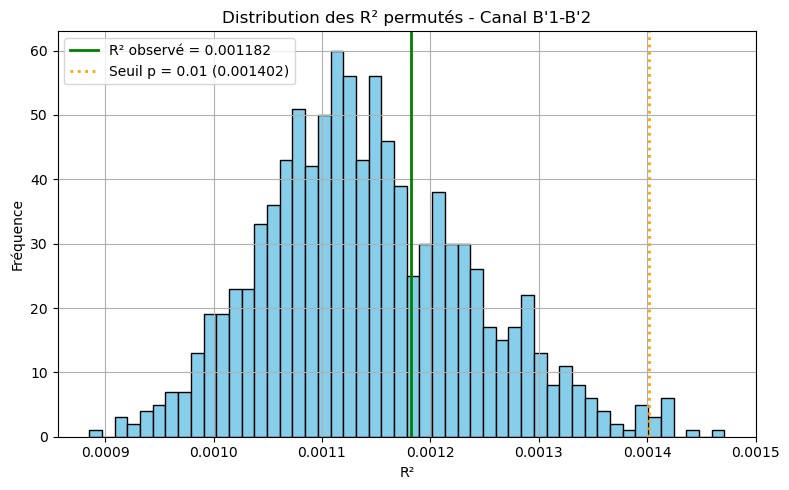

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

chan_idx = 0

# R² permutés et réel pour ce canal
r2_vals = r2_perm[chan_idx]
r2_obs = r2_real[chan_idx]

# Seuil à p = 0.01 (1% des permutés sont au-dessus)
threshold = np.percentile(r2_vals, 99)

# Histogramme
plt.figure(figsize=(8, 5))
plt.hist(r2_vals, bins=50, color='skyblue', edgecolor='black')
plt.axvline(r2_obs, color='green', linewidth=2, label=f"R² observé = {r2_obs:.4g}")
plt.axvline(threshold, color='orange', linestyle=':', linewidth=2, label=f"Seuil p = 0.01 ({threshold:.4g})")

plt.title(f"Distribution des R² permutés - Canal {sorted_channels_bipol[chan_idx]}")
plt.xlabel("R²")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


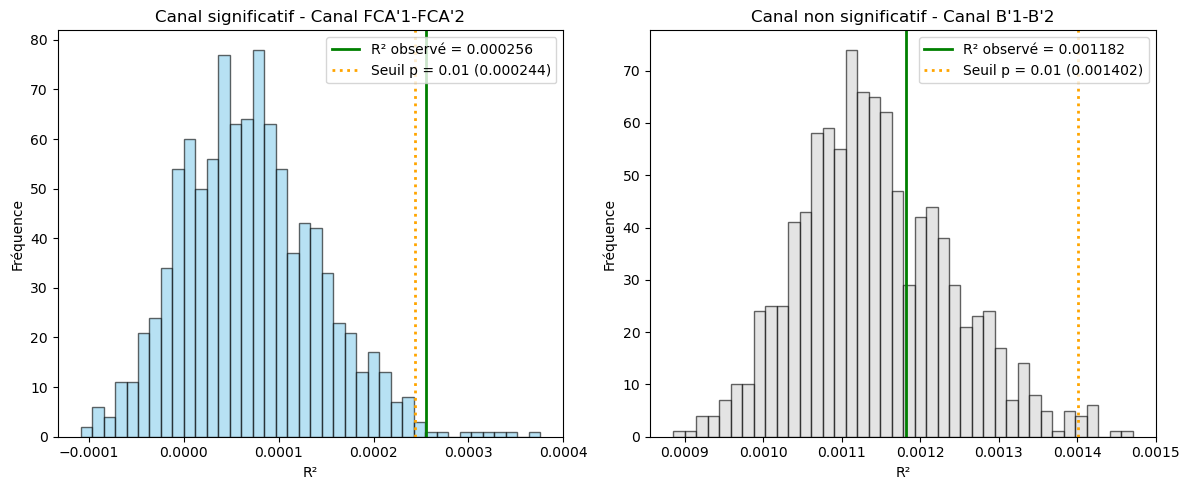

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcul des p-values et du seuil à 0.01
pvals = np.mean(r2_perm >= r2_real[:, None], axis=1)
seuils = np.percentile(r2_perm, 99, axis=1)
sig_chans = pvals < 0.01  # canaux significatifs

# 2. Index d'un canal significatif et non significatif
if np.any(sig_chans):
    chan_sig = np.where(sig_chans)[0][0]
else:
    raise ValueError("Aucun canal significatif trouvé.")

if np.any(~sig_chans):
    chan_nonsig = np.where(~sig_chans)[0][0]
else:
    raise ValueError("Aucun canal non significatif trouvé.")

# 3. Fonction de tracé d'histogramme pour un canal donné
def plot_histogram_chan(chan_idx, ax, color, title_prefix):
    r2_dist = r2_perm[chan_idx]
    r2_obs = r2_real[chan_idx]
    seuil = seuils[chan_idx]

    ax.hist(r2_dist, bins=40, color=color, edgecolor='k', alpha=0.6)
    ax.axvline(r2_obs, color='green',  linewidth=2, label=f"R² observé = {r2_obs:.6f}")
    ax.axvline(seuil, color='orange', linestyle=':', linewidth=2, label=f"Seuil p = 0.01 ({seuil:.6f})")
    ax.set_title(f"{title_prefix} - Canal {sorted_channels_bipol[chan_idx]}")
    ax.set_xlabel("R²")
    ax.set_ylabel("Fréquence")
    ax.legend()

# 4. Affichage côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_histogram_chan(chan_sig, axs[0], color='skyblue', title_prefix="Canal significatif")
plot_histogram_chan(chan_nonsig, axs[1], color='lightgrey', title_prefix="Canal non significatif")
plt.tight_layout()
plt.show()


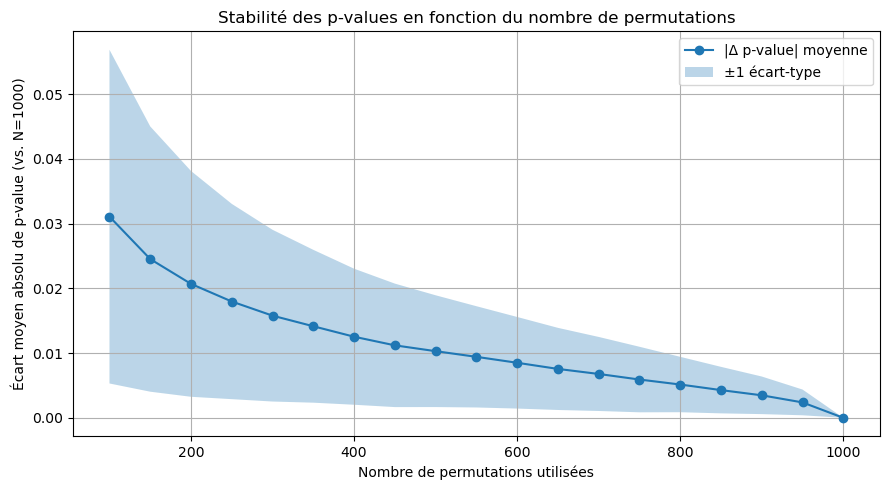

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
N_max = r2_perm.shape[1]  # ici 1000
Ns = np.arange(100, N_max + 1, 50)  # de 100 à 1000
n_repeats = 50  # pour lisser la variabilité liée au tirage aléatoire

# Pval de référence (à N=1000)
pval_ref = np.mean(r2_perm >= r2_real[:, None], axis=1)

mean_abs_delta_p = []
std_abs_delta_p = []

for N in Ns:
    abs_deltas = []
    for _ in range(n_repeats):
        idx = np.random.choice(r2_perm.shape[1], size=N, replace=False)
        r2_subset = r2_perm[:, idx]
        pval_N = np.mean(r2_subset >= r2_real[:, None], axis=1)

        delta = np.abs(pval_N - pval_ref)
        abs_deltas.append(delta)

    abs_deltas = np.stack(abs_deltas, axis=0)  # shape (n_repeats, n_chan)

    mean_abs_delta_p.append(abs_deltas.mean())
    std_abs_delta_p.append(abs_deltas.std())

# Tracé
plt.figure(figsize=(9, 5))
plt.plot(Ns, mean_abs_delta_p, label='|Δ p-value| moyenne', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_p) - np.array(std_abs_delta_p),
                 np.array(mean_abs_delta_p) + np.array(std_abs_delta_p),
                 alpha=0.3, label='±1 écart-type')
# plt.axhline(0.01, color='red', linestyle='--', label='Seuil de stabilité : 0.01')
plt.xlabel("Nombre de permutations utilisées")
plt.ylabel("Écart moyen absolu de p-value (vs. N=1000)")
plt.title("Stabilité des p-values en fonction du nombre de permutations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


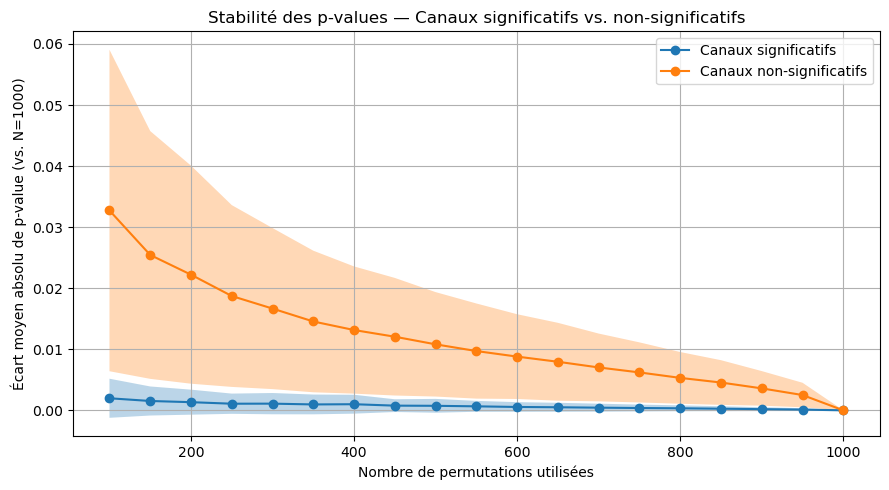

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
N_max = r2_perm.shape[1]  # ici 1000
Ns = np.arange(100, N_max + 1, 50)  # de 100 à 1000
n_repeats = 50  # pour lisser la variabilité liée au tirage aléatoire

# Pval de référence (N = 1000)
pval_ref = np.mean(r2_perm >= r2_real[:, None], axis=1)

# Séparer les canaux
is_sig = pval_ref < 0.01
is_nonsig = ~is_sig

# Initialisation des listes
mean_abs_delta_sig = []
std_abs_delta_sig = []

mean_abs_delta_nonsig = []
std_abs_delta_nonsig = []

for N in Ns:
    deltas_sig = []
    deltas_nonsig = []

    for _ in range(n_repeats):
        idx = np.random.choice(r2_perm.shape[1], size=N, replace=False)
        r2_subset = r2_perm[:, idx]
        pval_N = np.mean(r2_subset >= r2_real[:, None], axis=1)

        delta = np.abs(pval_N - pval_ref)
        deltas_sig.append(delta[is_sig])
        deltas_nonsig.append(delta[is_nonsig])

    deltas_sig = np.stack(deltas_sig, axis=0)
    deltas_nonsig = np.stack(deltas_nonsig, axis=0)

    mean_abs_delta_sig.append(deltas_sig.mean())
    std_abs_delta_sig.append(deltas_sig.std())

    mean_abs_delta_nonsig.append(deltas_nonsig.mean())
    std_abs_delta_nonsig.append(deltas_nonsig.std())

# Tracé
plt.figure(figsize=(9, 5))

# Canaux significatifs
plt.plot(Ns, mean_abs_delta_sig, label='Canaux significatifs', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_sig) - np.array(std_abs_delta_sig),
                 np.array(mean_abs_delta_sig) + np.array(std_abs_delta_sig),
                 alpha=0.3)

# Canaux non-significatifs
plt.plot(Ns, mean_abs_delta_nonsig, label='Canaux non-significatifs', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_nonsig) - np.array(std_abs_delta_nonsig),
                 np.array(mean_abs_delta_nonsig) + np.array(std_abs_delta_nonsig),
                 alpha=0.3)

plt.xlabel("Nombre de permutations utilisées")
plt.ylabel("Écart moyen absolu de p-value (vs. N=1000)")
plt.title("Stabilité des p-values — Canaux significatifs vs. non-significatifs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
from joblib import Parallel, delayed

# Création des X complets : (base + pred)
X_sorc_all = [np.concatenate((X_sorc_acoustic, Xp_sorc_predictive[:, :, i]), axis=1) for i in range(Xp_sorc_predictive.shape[2])]
feats = list(range(X_sorc_all[0].shape[1]))  # tous les colonnes

# Fonction unitaire pour une permutation
def run_trf(X_sel):
    trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
    trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
    best_alpha = trf.get_best_alpha()

    r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
    r2_mean = np.mean(r2, axis=0)  # moyenne sur les splits

    coef = trf.get_coef()
    coef_selected = coef[np.arange(coef.shape[0])[:,None,None],
                         np.arange(coef.shape[1])[None,:,None],
                         np.arange(coef.shape[2])[None,None,:],
                         best_alpha]  # shape (T, R, C)
    
    return r2_mean, coef_selected

# TRF sur chaque X en parallèle
results = Parallel(n_jobs=4, verbose=10)(
    delayed(run_trf)(X_i[:, feats]) for X_i in X_sorc_all
)

# Récupération des R² et TRF
r2_all = np.stack([r for r, _ in results], axis=1)  # (n_chan, n_perm+1)

trf_betas = results[0][1]  # coeffs non permutés uniquement (i == 0)

# Calcul des p-valeurs
r2_real_sorciere = r2_all[:, 0]
r2_perm_sorciere = r2_all[:, 1:]
pval_sorciere = np.mean(r2_perm_sorciere >= r2_real_sorciere[:, None], axis=1)

# Sauvegarde en .mat
scipy.io.savemat(out_path + '/sorciere_predictive.mat', {
    'r2_real': r2_real_sorciere,
    'r2_perm': r2_perm_sorciere,
    'pval': pval_sorciere,
    'kernels': trf_betas,
    'channels': sorted_channels_bipol,
    'fs': fs
})


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [58]:
def plot_r2_channel_hist(r2_real, r2_perm, channel_names, chan, title_prefix=""):
    """
    Affiche l'histogramme de la distribution des R² permutés pour un canal donné.

    Args:
        r2_real (np.ndarray): shape (n_channels,)
        r2_perm (np.ndarray): shape (n_channels, n_permut)
        channel_names (list of str): noms des électrodes
        chan (int or str): index (int) ou nom (str) du canal à afficher
        title_prefix (str): préfixe pour titre ou nom de fichier
    """
    # Index du canal
    if isinstance(chan, str):
        if chan not in channel_names:
            raise ValueError(f"Canal '{chan}' introuvable.")
        chan_idx = channel_names.index(chan)
    else:
        chan_idx = int(chan)
        if chan_idx < 0 or chan_idx >= len(channel_names):
            raise ValueError(f"Index de canal hors bornes : {chan_idx}")

    chan_label = channel_names[chan_idx]

    plt.figure(figsize=(8, 5))
    plt.hist(r2_perm[chan_idx], bins='auto', color='lightgray', edgecolor='black', label='Permutations')
    plt.axvline(r2_real[chan_idx], color='red', linestyle='dashed', linewidth=2, label='R² réel')
    plt.xlabel('Score R²')
    plt.ylabel('Nombre de permutations')
    plt.title(f"{title_prefix} R² - Canal {chan_label}")
    plt.legend()
    plt.tight_layout()  
    plt.show()


In [59]:
def plot_r2_permutation_hist(r2_real, r2_perm, title_prefix=""):
    """
    Affiche un histogramme de tous les R² permutés (canal × permut)
    avec les R² réels superposés (1 par canal).
    """
    r2_perm_flat = r2_perm.flatten()  # Toutes les permutations, tous canaux
    r2_real_flat = r2_real            # Un R² réel par canal

    plt.figure(figsize=(8, 5))
    plt.hist(r2_perm_flat, bins='auto', color='lightgray', edgecolor='black', label='Permutations')
    for r in r2_real_flat:
        plt.axvline(r, color='red', linestyle='dashed', linewidth=1, alpha=0.6)

    plt.xlabel("Score R²")
    plt.ylabel("Nombre d'occurrences (tous canaux × permutations)")
    plt.xlim(0, np.percentile(r2_perm_flat, 99.5))  # ou max(r2_real)+eps
    plt.title(f"{title_prefix} R² : tous canaux et permutations")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_r2_permutation_hist_significant_only(r2_real, r2_perm, pval, alpha=0.05, title_prefix=""):
    """
    Histogramme de tous les R² permutés (tous canaux × permutations),
    mais on ne trace que les R² réels significatifs (p < alpha).
    """
    r2_perm_flat = r2_perm.flatten()
    sig_channels = np.where(pval < alpha)[0]
    
    plt.figure(figsize=(10, 5))
    plt.hist(r2_perm_flat, bins='auto', color='lightgray', edgecolor='black', label='Permutations')
    
    for ch in sig_channels:
        plt.axvline(r2_real[ch], color='red', linestyle='dashed', linewidth=1.5, alpha=0.8)
    
    plt.xlabel("Score R²")
    plt.ylabel("Occurrences (tous canaux × permutations)")
    plt.title(f"{title_prefix} — R² réels des canaux significatifs (p < {alpha})")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Pianos : acoustic TRF

In [71]:
from scipy.io import savemat
from sklearn.preprocessing import scale
import numpy as np
import gc

# Paramètres
tw_trf = [-2, 2]  # en secondes
coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))
alphas = [1e-4, 1e-2, 1e2, 1e4, 1e6, 1e8]

# Données : X = régressseurs acoustiques, Y = EEG
X = X_piano_acoustic
Y = np.squeeze(pianos_ultimate)

# TRF
trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain = 'frequency')
trf.xval_eval(X, Y, n_splits=5, fit_mode='direct', verbose=False)

# Sélection des meilleurs alpha par canal
best_alpha = trf.get_best_alpha()
r2 = trf.scores[
    np.arange(trf.scores.shape[0])[:, None],
    np.arange(trf.scores.shape[1])[None, :],
    best_alpha
]
r2_acoustic = np.mean(r2, axis=0)

# Coefficients associés
coef = trf.get_coef()
trf_betas_acoustic = coef[
    np.arange(coef.shape[0])[:, None, None],
    np.arange(coef.shape[1])[None, :, None],
    np.arange(coef.shape[2])[None, None, :],
    best_alpha
]

# Sauvegarde
savemat(out_path + '/pianos_acoustic.mat', {
    'r2': r2_acoustic,
    'kernels': trf_betas_acoustic,
    'channels': sorted_channels_bipol,
    'fs': fs
})

gc.collect()
print("✅ Modèle acoustique sans permutation terminé et sauvegardé.")


C:\Users\nadege\AppData\Local\Temp\ipykernel_10148\265089799.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefs_times = np.linspace(tw_trf[0], tw_trf[1], int(np.diff(tw_trf) * fs + 1))


✅ Modèle acoustique sans permutation terminé et sauvegardé.


### Pianos : predictive TRF

In [74]:
import os
import numpy as np
import scipy.io
from joblib import Parallel, delayed
from tqdm import tqdm  # Facultatif pour barre de progression

# ========= CONFIGURATION =========
N_PERMUT = 1000
batch_size = 100
X_all = [np.concatenate((X_piano_acoustic, Xp_piano_predictive[:, :, i]), axis=1) for i in range(N_PERMUT + 1)]
n_batches = (N_PERMUT + 1) // batch_size + int((N_PERMUT + 1) % batch_size > 0)
feats = list(range(X_all[0].shape[1]))  # toutes les colonnes de X

# ========= TRF UNIT FUNCTION =========
def run_trf(X_sel):
    trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
    trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
    best_alpha = trf.get_best_alpha()
    r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
    r2_mean = np.mean(r2, axis=0)
    coef = trf.get_coef()
    coef_selected = coef[np.arange(coef.shape[0])[:, None, None],
                         np.arange(coef.shape[1])[None, :, None],
                         np.arange(coef.shape[2])[None, None, :],
                         best_alpha]
    return r2_mean, coef_selected

# ========= LANCEMENT PAR BATCH =========
for b in range(n_batches):
    batch_file = f"{out_path}/predictive_batch_piano{b}.mat"
    if os.path.exists(batch_file):
        print(f"[Batch {b}] déjà existant, on saute.")
        continue

    start_idx = b * batch_size
    end_idx = min((b + 1) * batch_size, len(X_all))
    X_batch = X_all[start_idx:end_idx]

    print(f"[Batch {b}] Traitement de {start_idx} à {end_idx - 1}")
    results = Parallel(n_jobs=4, verbose=10)(
        delayed(run_trf)(X_i[:, feats]) for X_i in X_batch
    )

    r2_batch = np.stack([r for r, _ in results], axis=1)
    kernels_batch = results[0][1] if b == 0 else []  # seulement pour le 1er batch

    scipy.io.savemat(batch_file, {
        'r2_batch': r2_batch,
        'kernels': kernels_batch,
    })


[Batch 0] Traitement de 0 à 99


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 10.0min finished


[Batch 1] Traitement de 100 à 199


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.7min finished


[Batch 2] Traitement de 200 à 299


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.7min finished


[Batch 3] Traitement de 300 à 399


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   46.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.5min finished


[Batch 4] Traitement de 400 à 499


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.5min finished


[Batch 5] Traitement de 500 à 599


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.4min finished


[Batch 6] Traitement de 600 à 699


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.6min finished


[Batch 7] Traitement de 700 à 799


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 10.1min finished


[Batch 8] Traitement de 800 à 899


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   46.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 10.0min finished


[Batch 9] Traitement de 900 à 999


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   48.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.9min finished


[Batch 10] Traitement de 1000 à 1000


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.7s finished


In [86]:
# ========= Fusion de tous les batchs =========
all_r2 = []
for b in range(n_batches):
    batch_file = f"{out_path}/predictive_batch_piano{b}.mat"
    mat = scipy.io.loadmat(batch_file)
    all_r2.append(mat['r2_batch'])

r2_all_piano = np.concatenate(all_r2, axis=1)
r2_real_piano = r2_all_piano[:, 0]
r2_perm_piano = r2_all_piano[:, 1:]

# ========= Calcul des p-values =========
pval_piano = np.mean(r2_perm_piano >= r2_real_piano[:, None], axis=1)

# ========= Sauvegarde finale =========
scipy.io.savemat(f"{out_path}/piano_predictive_final.mat", {
    'r2_real': r2_real_piano,
    'r2_perm': r2_perm_piano,
    'pval': pval_piano,
    'kernels': mat['kernels'],  # depuis batch 0
    'channels': sorted_channels_bipol,
    'fs': fs
})


In [62]:
from joblib import Parallel, delayed

# Création des X complets : (base + pred)
X_piano_all = [np.concatenate((X_piano_acoustic, Xp_piano_predictive[:, :, i]), axis=1) for i in range(Xp_piano_predictive.shape[2])]
feats = list(range(X_piano_all[0].shape[1]))  # tous les colonnes

# Fonction unitaire pour une permutation
def run_trf(X_sel):
    trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
    trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
    best_alpha = trf.get_best_alpha()

    r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
    r2_mean = np.mean(r2, axis=0)  # moyenne sur les splits

    coef = trf.get_coef()
    coef_selected = coef[np.arange(coef.shape[0])[:,None,None],
                         np.arange(coef.shape[1])[None,:,None],
                         np.arange(coef.shape[2])[None,None,:],
                         best_alpha]  # shape (T, R, C)
    
    return r2_mean, coef_selected

# TRF sur chaque X en parallèle
results = Parallel(n_jobs=4, verbose=10)(
    delayed(run_trf)(X_i[:, feats]) for X_i in X_piano_all
)

# Récupération des R² et TRF
r2_all = np.stack([r for r, _ in results], axis=1)  # (n_chan, n_perm+1)

trf_betas = results[0][1]  # coeffs non permutés uniquement (i == 0)

# Calcul des p-valeurs
r2_real_piano = r2_all[:, 0]
r2_perm_piano = r2_all[:, 1:]
pval_piano = np.mean(r2_perm_piano >= r2_real_piano[:, None], axis=1)

# Sauvegarde en .mat
scipy.io.savemat(out_path + '/pianos_predictive.mat', {
    'r2_real': r2_real_piano,
    'r2_perm': r2_perm_piano,
    'pval': pval_piano,
    'kernels': trf_betas,
    'channels': sorted_channels_bipol,
    'fs': fs
})


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 101 out of 101 | elapsed: 10.3min finished


### Piano : stat vizualisation

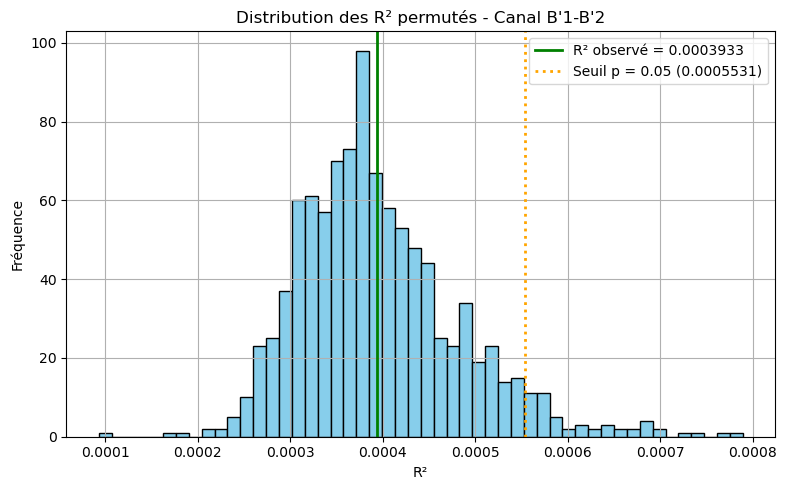

In [87]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

chan_idx = 0

# R² permutés et réel pour ce canal
r2_vals = r2_perm_piano[chan_idx]
r2_obs = r2_real_piano[chan_idx]

# Seuil à p = 0.05 (5% des permutés sont au-dessus)
threshold = np.percentile(r2_vals, 95)

# Histogramme
plt.figure(figsize=(8, 5))
plt.hist(r2_vals, bins=50, color='skyblue', edgecolor='black')
plt.axvline(r2_obs, color='green', linewidth=2, label=f"R² observé = {r2_obs:.4g}")
plt.axvline(threshold, color='orange', linestyle=':', linewidth=2, label=f"Seuil p = 0.05 ({threshold:.4g})")

plt.title(f"Distribution des R² permutés - Canal {sorted_channels_bipol[chan_idx]}")
plt.xlabel("R²")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


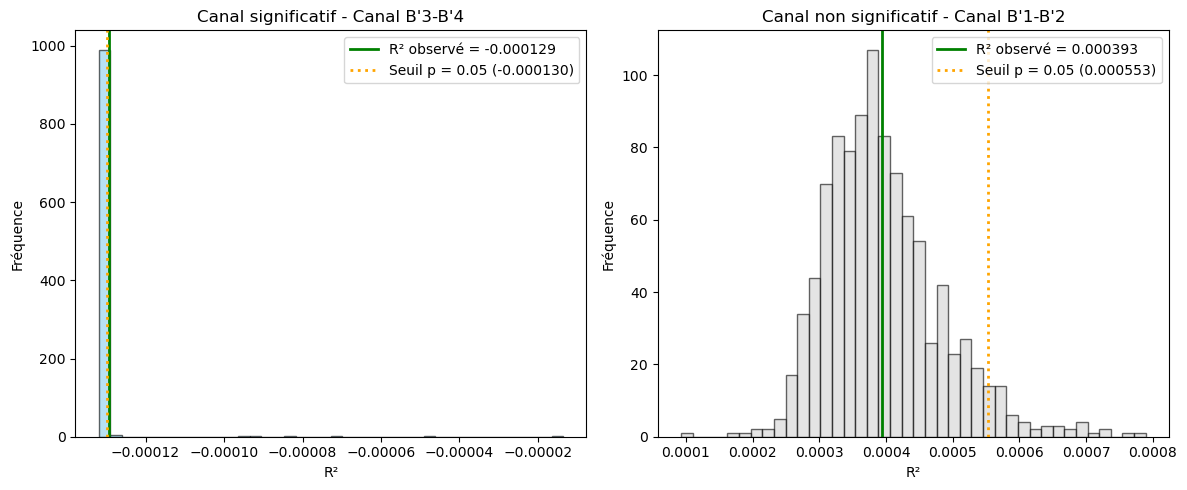

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcul des p-values et du seuil à 0.05
pval_piano = np.mean(r2_perm_piano >= r2_real_piano[:, None], axis=1)
seuils = np.percentile(r2_perm_piano, 95, axis=1)
sig_chans = pval_piano < 0.05  # canaux significatifs

# 2. Index d'un canal significatif et non significatif
if np.any(sig_chans):
    chan_sig = np.where(sig_chans)[0][0]
else:
    raise ValueError("Aucun canal significatif trouvé.")

if np.any(~sig_chans):
    chan_nonsig = np.where(~sig_chans)[0][0]
else:
    raise ValueError("Aucun canal non significatif trouvé.")

# 3. Fonction de tracé d'histogramme pour un canal donné
def plot_histogram_chan(chan_idx, ax, color, title_prefix):
    r2_dist = r2_perm_piano[chan_idx]
    r2_obs = r2_real_piano[chan_idx]
    seuil = seuils[chan_idx]

    ax.hist(r2_dist, bins=40, color=color, edgecolor='k', alpha=0.6)
    ax.axvline(r2_obs, color='green',  linewidth=2, label=f"R² observé = {r2_obs:.6f}")
    ax.axvline(seuil, color='orange', linestyle=':', linewidth=2, label=f"Seuil p = 0.05 ({seuil:.6f})")
    ax.set_title(f"{title_prefix} - Canal {sorted_channels_bipol[chan_idx]}")
    ax.set_xlabel("R²")
    ax.set_ylabel("Fréquence")
    ax.legend()

# 4. Affichage côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_histogram_chan(chan_sig, axs[0], color='skyblue', title_prefix="Canal significatif")
plot_histogram_chan(chan_nonsig, axs[1], color='lightgrey', title_prefix="Canal non significatif")
plt.tight_layout()
plt.show()

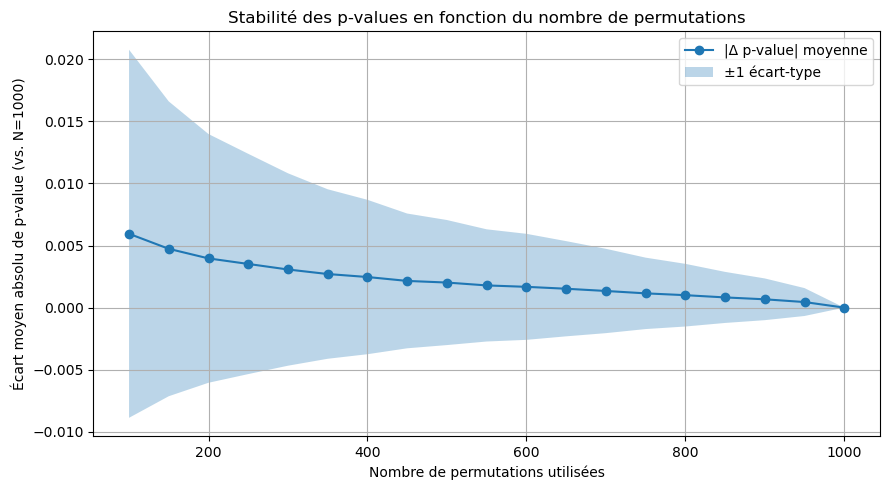

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
N_max = r2_perm_piano.shape[1]  # ici 1000
Ns = np.arange(100, N_max + 1, 50)  # de 100 à 1000
n_repeats = 50  # pour lisser la variabilité liée au tirage aléatoire

# Pval de référence (à N=1000)
pval_ref = np.mean(r2_perm_piano >= r2_real_piano[:, None], axis=1)

mean_abs_delta_p = []
std_abs_delta_p = []

for N in Ns:
    abs_deltas = []
    for _ in range(n_repeats):
        idx = np.random.choice(r2_perm_piano.shape[1], size=N, replace=False)
        r2_subset = r2_perm_piano[:, idx]
        pval_N = np.mean(r2_subset >= r2_real_piano[:, None], axis=1)

        delta = np.abs(pval_N - pval_ref)
        abs_deltas.append(delta)

    abs_deltas = np.stack(abs_deltas, axis=0)  # shape (n_repeats, n_chan)

    mean_abs_delta_p.append(abs_deltas.mean())
    std_abs_delta_p.append(abs_deltas.std())

# Tracé
plt.figure(figsize=(9, 5))
plt.plot(Ns, mean_abs_delta_p, label='|Δ p-value| moyenne', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_p) - np.array(std_abs_delta_p),
                 np.array(mean_abs_delta_p) + np.array(std_abs_delta_p),
                 alpha=0.3, label='±1 écart-type')
# plt.axhline(0.01, color='red', linestyle='--', label='Seuil de stabilité : 0.01')
plt.xlabel("Nombre de permutations utilisées")
plt.ylabel("Écart moyen absolu de p-value (vs. N=1000)")
plt.title("Stabilité des p-values en fonction du nombre de permutations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


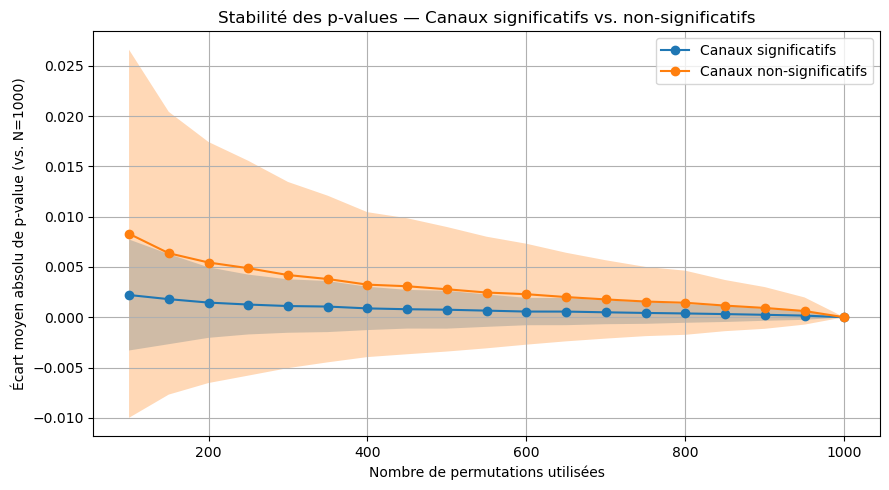

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
N_max = r2_perm.shape[1]  # ici 1000
Ns = np.arange(100, N_max + 1, 50)  # de 100 à 1000
n_repeats = 50  # pour lisser la variabilité liée au tirage aléatoire

# Pval de référence (N = 1000)
pval_ref = np.mean(r2_perm_piano >= r2_real_piano[:, None], axis=1)

# Séparer les canaux
is_sig = pval_ref < 0.05
is_nonsig = ~is_sig

# Initialisation des listes
mean_abs_delta_sig = []
std_abs_delta_sig = []

mean_abs_delta_nonsig = []
std_abs_delta_nonsig = []

for N in Ns:
    deltas_sig = []
    deltas_nonsig = []

    for _ in range(n_repeats):
        idx = np.random.choice(r2_perm_piano.shape[1], size=N, replace=False)
        r2_subset = r2_perm_piano[:, idx]
        pval_N = np.mean(r2_subset >= r2_real_piano[:, None], axis=1)

        delta = np.abs(pval_N - pval_ref)
        deltas_sig.append(delta[is_sig])
        deltas_nonsig.append(delta[is_nonsig])

    deltas_sig = np.stack(deltas_sig, axis=0)
    deltas_nonsig = np.stack(deltas_nonsig, axis=0)

    mean_abs_delta_sig.append(deltas_sig.mean())
    std_abs_delta_sig.append(deltas_sig.std())

    mean_abs_delta_nonsig.append(deltas_nonsig.mean())
    std_abs_delta_nonsig.append(deltas_nonsig.std())

# Tracé
plt.figure(figsize=(9, 5))

# Canaux significatifs
plt.plot(Ns, mean_abs_delta_sig, label='Canaux significatifs', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_sig) - np.array(std_abs_delta_sig),
                 np.array(mean_abs_delta_sig) + np.array(std_abs_delta_sig),
                 alpha=0.3)

# Canaux non-significatifs
plt.plot(Ns, mean_abs_delta_nonsig, label='Canaux non-significatifs', marker='o')
plt.fill_between(Ns,
                 np.array(mean_abs_delta_nonsig) - np.array(std_abs_delta_nonsig),
                 np.array(mean_abs_delta_nonsig) + np.array(std_abs_delta_nonsig),
                 alpha=0.3)

plt.xlabel("Nombre de permutations utilisées")
plt.ylabel("Écart moyen absolu de p-value (vs. N=1000)")
plt.title("Stabilité des p-values — Canaux significatifs vs. non-significatifs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Generate a .txt file with scores 

In [ ]:
# # Create the full path to the file
# filename = os.path.join(out_path, 'scores.txt')

# with open(filename, 'w') as file:
#     # Write the header with aligned columns
#     file.write(f'{"Channel":<10}{"Speech Acoustic (in %)":<25}{"Speech Predictif (in %)":<30}{"Music Acoustic (in %)":<30}{"Music Predictif (in %)":<30}\n')

#     # Write data to the file
#     for chan, scr1, scr2, scr3, scr4 in zip(sorted_channels_bipol, sorciere_regs_acoustic_scores_cv, sorciere_regs_predictive_scores_cv, pianos_regs_acoustic_scores_cv, pianos_regs_predictive_scores_cv):
#         file.write(f'{chan:<15}{round(scr1*100,2):<30}{round(scr2*100,2):<25}{round(scr3*100,2):<30}{round(scr4*100,2):<20}\n')


## Plot results

### R2, PCI & ERP - with matlab

In [102]:
import matlab.engine
from datetime import datetime

print('Start at :', datetime.now())


# Démarrer le moteur MATLAB
eng = matlab.engine.start_matlab()
# run MATLAB script
eng.eval(f"out_path = '{out_path}'; run('C:/Users/nadege/Desktop/camille/seeg/agnes/sEEG_rsqr_pci.m')", nargout=0)
#eng.eval(f"out_path = '{out_path}'; run('//dynaserv/home/trebuchon/Desktop/Python_code/sEEG_rsqr_pci.m')", nargout=0)


print("End at:", datetime.now())

Start at : 2025-06-26 14:43:57.301037


MatlabExecutionError: 
  File C:\Users\nadege\Desktop\camille\seeg\agnes\sEEG_rsqr_pci.m, line 81, in sEEG_rsqr_pci

  File C:\Program Files\MATLAB\R2023a\toolbox\matlab\lang\run.m, line 91, in run
Unable to find file or directory 'C:\Users\nadege\Desktop\camille\seeg\agnes\Gab_Sa\1000permut\sorciere_predictive.mat'.
